# 라이브러리 버전 확인하기
- 사용할 라이브러리 버전을 확인해봐요.

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
from PIL import Image

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# 데이터 로드
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

In [4]:
from tensorflow.keras.layers import Dense

num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg'
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

In [5]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [6]:
# 이미지 전처리
def normalize_and_resize_img(input):
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(normalize_and_resize_img, num_parallel_calls=2)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [7]:
# 데이터셋에 전처리와 배치처리를 적용합니다.
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_val_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [8]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy']
)

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# EarlyStopping과 ModelCheckpoint 콜백 설정
early_stopping = EarlyStopping(
    monitor='val_loss',  # 검증 손실 기준
    patience=2,          # 개선되지 않는 에포크 수
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    filepath='best_model.h5',  # 모델이 저장될 파일 이름
    monitor='val_loss',        # 검증 손실 기준
    save_best_only=True,       # 가장 좋은 성능의 모델만 저장
    verbose=1
)

# 모델 학습
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples / 16),
    validation_steps=int(ds_info.splits['test'].num_examples / 16),
    epochs=20,
    validation_data=ds_val_norm,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/20
750/750 [==============================] - 164s 208ms/step - loss: 2.2534 - accuracy: 0.4343 - val_loss: 3.3352 - val_accuracy: 0.2199

Epoch 00001: val_loss improved from inf to 3.33522, saving model to best_model.h5


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/20
750/750 [==============================] - 155s 206ms/step - loss: 0.6771 - accuracy: 0.8168 - val_loss: 1.1840 - val_accuracy: 0.6566

Epoch 00002: val_loss improved from 3.33522 to 1.18398, saving model to best_model.h5
Epoch 3/20
750/750 [==============================] - 155s 207ms/step - loss: 0.1791 - accuracy: 0.9697 - val_loss: 1.0893 - val_accuracy: 0.6805

Epoch 00003: val_loss improved from 1.18398 to 1.08927, saving model to best_model.h5
Epoch 4/20
750/750 [==============================] - 155s 207ms/step - loss: 0.0565 - accuracy: 0.9958 - val_loss: 0.9535 - val_accuracy: 0.7248

Epoch 00004: val_loss improved from 1.08927 to 0.95349, saving model to best_model.h5
Epoch 5/20
750/750 [==============================] - 169s 226ms/step - loss: 0.0282 - accuracy: 0.9990 - val_loss: 1.0336 - val_accuracy: 0.7071

Epoch 00005: val_loss did not improve from 0.95349
Epoch 6/20
750/750 [==============================] - 155s 207ms/step - loss: 0.0203 - accuracy: 0.9991

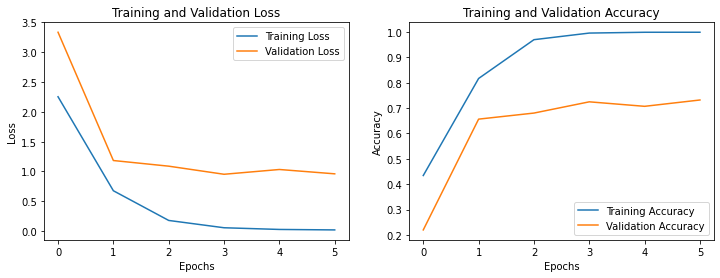

In [10]:
# 학습 그래프 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_cam_model.history['loss'], label='Training Loss')
plt.plot(history_cam_model.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history_cam_model.history['accuracy'], label='Training Accuracy')
plt.plot(history_cam_model.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()

In [34]:
import os

cam_model_path = '/aiffel/class_activation_map/best_model.h5'

# 경로가 없으면 새로 만듭니다.
os.makedirs(os.path.dirname(cam_model_path), exist_ok=True)

# 모델 가중치 저장
cam_model.save(cam_model_path)

In [35]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

100


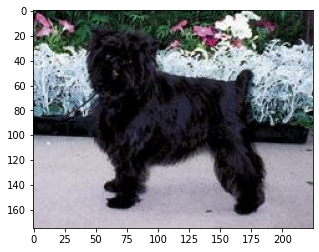

In [36]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [37]:
import os
cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

# CAM 구현하기
- 1. 이번 노드에 나왔던 CAM을 직접 구현해 봅시다.

In [38]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0]
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image)
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height))
    return cam_image

- 2. 만든 함수로 CAM 이미지를 생성합시다.

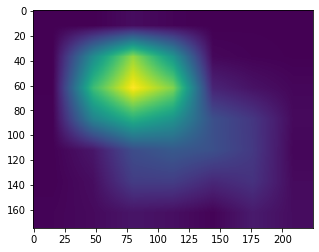

In [39]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

- 3. 원본 이미지와 CAM 이미지를 입력으로 받고 두 개의 이미지의 투명도를 조정, 하나의 이미지에서 원본과 CAM을 겹쳐 보여주는 visualize_cam_on_image() 함수를 만들어보세요.

In [40]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

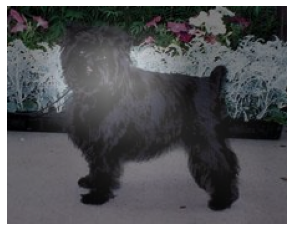

In [41]:
# visualize_cam_on_image() 함수 사용

if isinstance(item['image'], np.ndarray):
    origin_image = item['image'].astype(np.uint8)
else:
    origin_image = item['image'].numpy().astype(np.uint8)

# cam_image는 Grad-CAM에서 생성된 2D 배열이므로 3채널로 변환합니다.
cam_image_3channel = np.stack([cam_image * 255] * 3, axis=-1).astype(np.uint8)

# Grad-CAM 이미지와 원본 이미지를 시각적으로 합성합니다.
blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.axis('off')
plt.show()

# Grad-CAM 구현하기
- 1. 이번 노드에 나왔던 Grad-CAM을 직접 구현해 봅시다

In [42]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
        loss = pred[:, class_idx]
    output = conv_output[0]
    grad_val = tape.gradient(loss, conv_output)[0]

    weights = np.mean(grad_val, axis=(0, 1))
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

- 2. 만든 함수로 여러 레이어의 CAM 이미지를 뽑아서 직접 확인해 보세요.

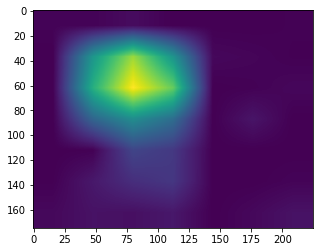

In [43]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

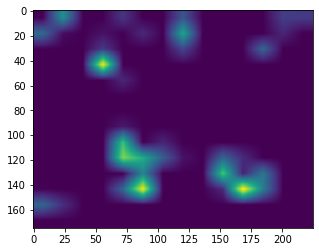

In [44]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

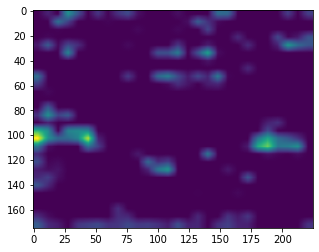

In [45]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

- 3. 위에서 만든 이미지 visualize_cam_on_image() 함수로 이미지를 시각화해 보세요.

In [46]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

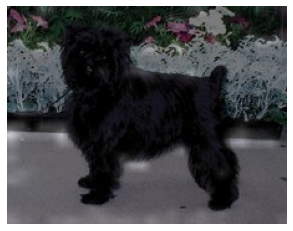

In [47]:
if isinstance(item['image'], np.ndarray):
    origin_image = item['image'].astype(np.uint8)
else:
    origin_image = item['image'].numpy().astype(np.uint8)

# cam_image는 Grad-CAM에서 생성된 2D 배열이므로 3채널로 변환합니다.
grad_cam_image_3channel = np.stack([grad_cam_image * 255] * 3, axis=-1).astype(np.uint8)

# Grad-CAM 이미지와 원본 이미지를 시각적으로 합성합니다.
blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.axis('off')
plt.show()

# 바운딩 박스 구하기
- 1. 제시된 코드를 참고해, 직접 Grad-CAM으로 얻은 CAM을 통해서 바운딩 박스를 얻어보세요.

In [48]:
# 바운딩 박스 생성 함수 및 IoU 계산
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image * 255).astype(np.uint8)

    contours, _ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return np.zeros((4, 2), dtype=np.int32)  # 빈 바운딩 박스를 반환

    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)  # numpy 배열로 변환
    return rect

In [49]:
rect = get_bbox(cam_image)
if isinstance(rect, np.ndarray):
    rect = np.array(rect, dtype=np.int32)

- 2. 1)에서 얻은 바운딩 박스를 시각화해 보세요.

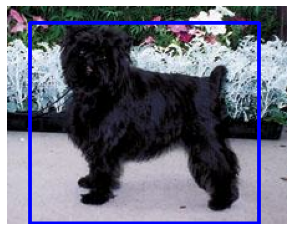

In [50]:
image = copy.deepcopy(item['image']).astype(np.uint8)
image = cv2.drawContours(image, [rect], -1, (0, 0, 255), 2)

plt.imshow(image)
plt.axis('off')
plt.show()

In [51]:
def rect_to_minmax(rect, image):
    y_min, x_min = np.min(rect[:, 1]), np.min(rect[:, 0])
    y_max, x_max = np.max(rect[:, 1]), np.max(rect[:, 0])
    return [y_min / float(image.shape[0]), x_min / float(image.shape[1]), y_max / float(image.shape[0]), x_max / float(image.shape[1])]

In [52]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.07428571428571429, 0.08, 0.9942857142857143, 0.8977777777777778]

In [53]:
item['objects']['bbox']

array([[0.08      , 0.16444445, 0.94857144, 0.84      ]], dtype=float32)

# IoU 구하기
- 1. 정답 바운딩 박스(ground truth) 와 예측값 바운딩 박스(prediction box) 두 가지를 이용해서 IoU를 계산하는 get_iou() 함수를 만들어 주세요.

In [54]:
def get_iou(boxA, boxB):
    y_min, x_min = max(boxA[0], boxB[0]), max(boxA[1], boxB[1])
    y_max, x_max = min(boxA[2], boxB[2]), min(boxA[3], boxB[3])
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    return interArea / float(boxAArea + boxBArea - interArea)

In [55]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.7799082032505189

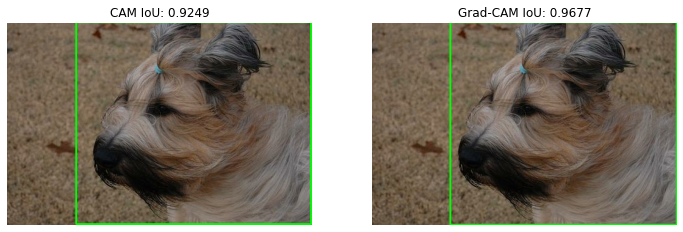

In [57]:
# CAM, Grad-CAM 바운딩 박스 및 IoU 시각화
item = get_one(ds_test)
cam_image = generate_cam(cam_model, item)
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)

cam_bbox_rect = get_bbox(cam_image)
grad_cam_bbox_rect = get_bbox(grad_cam_image)
true_bbox = item['objects']['bbox'][0]

cam_bbox = rect_to_minmax(cam_bbox_rect, item['image'])
grad_cam_bbox = rect_to_minmax(grad_cam_bbox_rect, item['image'])

cam_iou = get_iou(cam_bbox, true_bbox)
grad_cam_iou = get_iou(grad_cam_bbox, true_bbox)

image_with_cam = copy.deepcopy(item['image']).astype(np.uint8)
image_with_grad_cam = copy.deepcopy(item['image']).astype(np.uint8)

cv2.drawContours(image_with_cam, [cam_bbox_rect], 0, (0, 255, 0), 2)
cv2.drawContours(image_with_grad_cam, [grad_cam_bbox_rect], 0, (0, 255, 0), 2)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image_with_cam)
plt.title(f'CAM IoU: {cam_iou:.4f}')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_with_grad_cam)
plt.title(f'Grad-CAM IoU: {grad_cam_iou:.4f}')
plt.axis('off')

plt.show()

- 2. CAM과 Grad-CAM으로 얻은 바운딩 박스와 정답 바운딩 박스와의 IoU를 각각 비교해 봅시다.

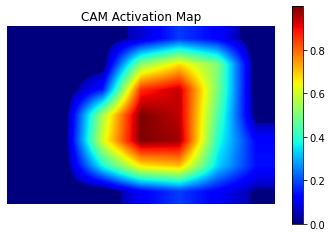

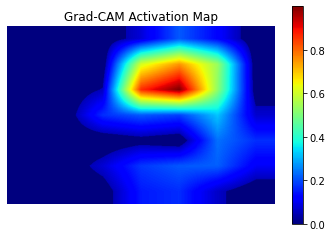

Adjusted CAM IoU: 0.9249
Adjusted Grad-CAM IoU: 0.9677


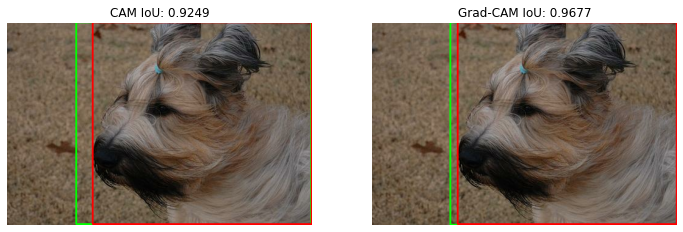

In [58]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import copy

# CAM과 Grad-CAM 활성화 맵 시각화 함수
def display_activation_map(activation_map, title='Activation Map'):
    plt.imshow(activation_map, cmap='jet')
    plt.colorbar()
    plt.title(title)
    plt.axis('off')
    plt.show()

# CAM과 Grad-CAM 바운딩 박스를 개선된 방법으로 생성
def get_improved_bbox(cam_image, score_thresh=0.05):
    cam_image[cam_image <= score_thresh] = 0
    cam_image = (cam_image * 255).astype(np.uint8)
    
    # 더 넓은 바운딩 박스를 생성하기 위해 cv2.boundingRect 사용
    contours, _ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return np.array([[0, 0], [0, 0], [0, 0], [0, 0]], dtype=np.int32)  # 빈 바운딩 박스 처리
    
    # 가장 큰 contour 선택
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    rect = np.array([
        [x, y], 
        [x + w, y], 
        [x + w, y + h], 
        [x, y + h]
    ], dtype=np.int32)
    
    return rect

# Bounding Box를 rect 형식으로 변환하는 함수
def convert_bbox_to_rect(bbox, image):
    height, width, _ = image.shape
    y_min = int(bbox[0] * height)
    x_min = int(bbox[1] * width)
    y_max = int(bbox[2] * height)
    x_max = int(bbox[3] * width)
    
    # rect 형식으로 변환
    rect = np.array([
        [x_min, y_min], 
        [x_max, y_min], 
        [x_max, y_max], 
        [x_min, y_max]
    ], dtype=np.int32)
    
    return rect

# CAM과 Grad-CAM 활성화 맵 확인
display_activation_map(cam_image, title='CAM Activation Map')
display_activation_map(grad_cam_image, title='Grad-CAM Activation Map')

# CAM 및 Grad-CAM 바운딩 박스 생성 및 IoU 계산
cam_bbox = rect_to_minmax(cam_bbox_rect, item['image'])
grad_cam_bbox = rect_to_minmax(grad_cam_bbox_rect, item['image'])
true_bbox = item['objects']['bbox'][0]  # True Bounding Box를 그대로 사용

# IoU 계산
cam_iou = get_iou(cam_bbox, true_bbox)
grad_cam_iou = get_iou(grad_cam_bbox, true_bbox)

print(f"Adjusted CAM IoU: {cam_iou:.4f}")
print(f"Adjusted Grad-CAM IoU: {grad_cam_iou:.4f}")

# 원본 이미지 복사하여 준비
image_with_cam = copy.deepcopy(item['image']).astype(np.uint8)
image_with_grad_cam = copy.deepcopy(item['image']).astype(np.uint8)

# CAM 바운딩 박스 그리기
cv2.drawContours(image_with_cam, [cam_bbox_rect], 0, (0, 255, 0), 2)  # 초록색 CAM
cv2.drawContours(image_with_cam, [convert_bbox_to_rect(item['objects']['bbox'][0], item['image'])], 0, (255, 0, 0), 2)  # 빨간색 정답

# Grad-CAM 바운딩 박스 그리기
cv2.drawContours(image_with_grad_cam, [grad_cam_bbox_rect], 0, (0, 255, 0), 2)  # 초록색 Grad-CAM
cv2.drawContours(image_with_grad_cam, [convert_bbox_to_rect(item['objects']['bbox'][0], item['image'])], 0, (255, 0, 0), 2)  # 빨간색 정답

# 시각화
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image_with_cam)
plt.title(f'CAM IoU: {cam_iou:.4f}')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_with_grad_cam)
plt.title(f'Grad-CAM IoU: {grad_cam_iou:.4f}')
plt.axis('off')

plt.show()

# 회고
- 재미있는 실습이었다.
- 그래프에서 과적합이 일어난 것 같아 여러 번 바꾸면서 시도했지만 이 결과가 최선이었다.
- IoU는 두 바운딩 박스가 겹치는 면적을 전체 합집합 면적으로 나누어 계산하고 겹치는 면적이 클수록 IoU 값이 커진다는 걸 알게 됐다.